# Module 3, Lab 2: Object Classification - ResNet

In this tutorial, we will gain some practical experience using Microsoft ResNet, a Deep Convolutional Neural Network (CNN) approach to object classification. Convolutional Neural Networks build up layers of convolutions, transforming an input image and distilling it down until they start recognizing composite features, with deeper layers of convolutions recognizing increasingly complex patterns. 

As you will have seen from our accompanying video lectures in this module, ResNet was invented by Researchers at Microsoft Research Asia (Kaiming He, Xiangyu Zhang, Shaoqing Ren and Jian Sun), and it won first place in both ILSVRC and MS COCO competitions in  2015. 

A great visual presentation from Kaiming He describing ResNet is available at:

* http://image-net.org/challenges/talks/ilsvrc2015_deep_residual_learning_kaiminghe.pdf. 

Whereas AlexNet (ILSVRC 2012 winner) had 8 layers, VGG (ILSRVC 2014) had 19 layers, and GoogleNet (ILSRVC 2014) had 22 layers, ResNet demonstrated a trainable network with a whopping 152 layers! This was quite a technical achievement at the time. ResNet managed this by resolving a phenomenon that had to this point been observed across many different datasets - namely, that deeper networks experienced higher training and test error than their shallower counterparts.

By contrast, deep ResNets can be easily trained, and in fact have lower training error and lower test error than comparable, shallower, networks.   Furthermore, ResNets can learn better features which are more transferrable to networks used for other tasks.  These better features lead to improved performance on object detection and segmentation tasks when using ResNet as the base classifier.

ResNets achieve this through the use of a technique called *Residual Deep Learning*. This is a technique that originated in Microsoft Research and involves *passing through* the main signal of the input data, so that the network ultimately "learns" on just the residual portions that differ between layers. This has proven, in practice, to allow the training of much deeper networks by avoiding issues that plague gradient descent on larger networks. These cells bypass convolution layers and then come back in later before rectified linear unit (ReLU).

For this task, we have chosen ResNet20 as our trained model architecture. In our next module, this ResNet20 model will be used as a base model, and we will build upon it to introduce concepts such as *Transfer Learning* for classification, and *Semantic Segmentation*.


# Setup Code

First, we need  to load the Microsoft Cognitive Toolkit (previously known as the CNTK) libraries and other dependencies for this exerise.

The Microsoft Cognitive Toolkit allows you to harness the intelligence within massive datasets through deep learning by providing uncompromised scaling, speed, and accuracy with commercial-grade quality and compatibility with the programming languages and algorithms you already use. 

The toolkit trains and evaluates deep learning algorithms faster than other available toolkits, scaling efficiently in a range of environments—from a CPU, to GPUs, to multiple machines—while maintaining accuracy.

It is built with sophisticated algorithms and production readers to work reliably with massive datasets. Skype, Cortana, Bing, Xbox, and industry-leading data scientists already use the Microsoft Cognitive Toolkit to develop commercial-grade AI.

The toolkit offers the most expressive, easy-to-use architecture available. Working with the languages and networks you know, like C++ and Python, it empowers you to customize any of the built-in training algorithms, or use your own.

We need version 2.4 of the Microsoft Cognitive Toolkit, so we'll use the Python package manager *pip* to upgrade if necessary. 

In [1]:
# Copyright (c) Microsoft. All rights reserved.
#
# Licensed under the MIT license. See LICENSE.md file in the project root
# for full license information.
# ==============================================================================

# For Azure Notebooks, we will update Microsoft Cognitive Toolkit version to 2.4 
# you can comment out the following line if you are running in your own local Jupyter Notebook setup and already have
# CNTK 2.4 installed
!pip install --upgrade --no-deps https://cntk.ai/PythonWheel/CPU-Only/cntk-2.4-cp35-cp35m-linux_x86_64.whl

import cntk as C
print ("Using Microsoft Cognitive Toolkit version {}".format(C.__version__))

import numpy as np
print ("Using numpy version {}".format(np.__version__))

    100% |████████████████████████████████| 179.7MB 5.7kB/s ta 0:00:011 0% |▎                               | 1.6MB 8.3MB/s eta 0:00:22    4% |█▍                              | 7.7MB 5.3MB/s eta 0:00:33    5% |█▊                              | 9.9MB 5.5MB/s eta 0:00:31    6% |██▏                             | 12.4MB 5.3MB/s eta 0:00:32    10% |███▍                            | 18.9MB 3.9MB/s eta 0:00:41    10% |███▌                            | 19.5MB 6.1MB/s eta 0:00:27    12% |████▏                           | 23.2MB 5.1MB/s eta 0:00:31    22% |███████▏                        | 40.2MB 9.2MB/s eta 0:00:16    29% |█████████▌                      | 53.3MB 6.8MB/s eta 0:00:19    31% |██████████▏                     | 57.4MB 4.8MB/s eta 0:00:26   34% |███████████                     | 62.2MB 5.8MB/s eta 0:00:21         | 66.0MB 7.0MB/s eta 0:00:17�███████████                   | 72.9MB 3.5MB/s eta 0:00:31 8.3MB/s eta 0:00:136.7MB 6.1MB/s eta 0:00:17    43% |█████████████▊                 

Now, let's import the rest of the Python routines we need.

In [2]:
%matplotlib inline

from __future__ import print_function
import os
from IPython.display import Image, display, SVG
import time
import seaborn
from tqdm import tqdm
import cv2

# ==============================================================================
# Import CNTK and helpers
#
from cntk import load_model
from cntk.initializer import he_normal, normal
from cntk.layers import AveragePooling, MaxPooling, BatchNormalization, Convolution, Dense
from cntk.ops import element_times, relu
#
# For Training
from cntk import cross_entropy_with_softmax, classification_error, reduce_mean
from cntk import Trainer, cntk_py
from cntk.io import MinibatchSource, ImageDeserializer, StreamDef, StreamDefs
from cntk.learners import momentum_sgd, momentum_schedule,  learning_parameter_schedule_per_sample
from cntk.debugging import *
from cntk.logging import *
import cntk.io.transforms as xforms


# ==============================================================================
#
# Paths relative to current python file.
abs_path   = os.path.dirname(".")
data_path  = os.path.join("/home/nbuser/data/M3", "CIFAR-10")

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


We are going to use the Cognitive Toolkit's default policy to use the best available device (GPU, if available, else CPU).

In [3]:
try:
    isUsingGPU # if this is our first time running, this will cause an exception as undefined
except NameError:
    try:
        isUsingGPU = C.device.try_set_default_device(C.device.gpu(0))
    except ValueError:
        isUsingGPU = False
        C.device.try_set_default_device(C.device.cpu())

print ("The Cognitive Toolkit is using the {} for processing.".format("GPU" if isUsingGPU else "CPU"))

The Cognitive Toolkit is using the CPU for processing.


## Basic Building Blocks of CNN

*Convolutional Neural Networks* (also known as *CNNs*, or *ConvNets*) typically stack convolutional layers, rectified linear unit (ReLU) activation layers, pooling layers, and finally fully connected layers. 

ResNet changes this slightly, and introduces a new trend towards smaller filters and deeper architectures, with fewer pooling and fully connected layers.

We need to create some basic building blocks for the ResNet model. Let's take a look at the Resnet *residual block*, which we will use to create our the full ResNet20 network architecture.

![The Residual Block](images/residual_block_color.svg "The Residual Block")

As you can see, the residual block consists of a stacking of convolutional, batch normalization, and rectified linear (ReLU) activation layers. This residual block is our basic building block for ResNet.  We explained how it works in our video lectures for this module, and will recap on this shortly.  

To start with, we're going to create two functions to help us stack convolutional layers with batch normalization layers, and then convolutional layers with batch normalization and ReLU layers:

In [4]:
#
# assembly components
#
# We're using a stride of (1,1) for the convolution - i.e. we stride (move) by 1 pixel horizontally and 1 pixel vertically...
#
# We're using he_hormal() for our initializer - this will set parameters to Gaussian distribution with mean 
#  0 and standard deviation of scale∗sqrt(2.0/fanIn)
#
# Batch normalization applies this formula to every input element (element-wise): 
#   y = (x - batch_mean) / (batch_stddev + epsilon) * scale + bias 
# where batch_mean and batch_stddev are estimated on the minibatch, and scale and bias are learned parameters.
#
# 
def conv_bn(input, filter_size, num_filters, strides=(1, 1), init=he_normal(), bn_init_scale=1):
    c = Convolution(filter_size, num_filters, activation=None, init=init, pad=True, strides=strides, bias=False)(input)
    r = BatchNormalization(map_rank=1, normalization_time_constant=4096, use_cntk_engine=False, init_scale=bn_init_scale, disable_regularization=True)(c)
    return r

def conv_bn_relu(input, filter_size, num_filters, strides=(1, 1), init=he_normal()):
    r = conv_bn(input, filter_size, num_filters, strides, init, 1)
    return relu(r)

So we now have a function to create a convolutional weights layer with back normalization at the end, and one which also has a rectified linear unit (ReLU) after it.  We're next going to combine both of these into the fundamental building block of ResNet, the *Residual Block*.


## The Residual Block and Skip Connections

The following two functions will create the residual block, and a version of the residual block that also adds in input passed through a single convolutional layer and batch norm.

![resnet_basic_blocks](images/resnet_basic_blocks.svg "ResNet basic building blocks")


In [5]:
#
# ResNet components
#
def resnet_basic(input, num_filters):
    c1 = conv_bn_relu(input, (3, 3), num_filters)
    c2 = conv_bn(c1, (3, 3), num_filters, bn_init_scale=1)
    p = c2 + input
    return relu(p)

def resnet_basic_inc(input, num_filters, strides=(2, 2)):
    c1 = conv_bn_relu(input, (3, 3), num_filters, strides)
    c2 = conv_bn(c1, (3, 3), num_filters, bn_init_scale=1)
    s = conv_bn(input, (1, 1), num_filters, strides) # Shortcut
    p = c2 + s
    return relu(p)

We can see the skip connection implemented above with the addition of c2 plus either the input layer or s, i.e.: 

$ p = c2 + input$

or

$p = c2 + s$


Now we need to create some code to stack layers together, increasing the number of filters and decreasing the spatial size of the data as it progresses through the network.

In [6]:

def resnet_basic_stack(input, num_stack_layers, num_filters): 
    assert(num_stack_layers >= 0)
    l = input
    for _ in range(num_stack_layers):
        l = resnet_basic(l, num_filters)
    return l

def resnet_bottleneck(input, out_num_filters, inter_out_num_filters):
    c1 = conv_bn_relu(input, (1, 1), inter_out_num_filters)
    c2 = conv_bn_relu(c1, (3, 3), inter_out_num_filters)
    c3 = conv_bn(c2, (1, 1), out_num_filters, bn_init_scale=0)
    p = c3 + input
    return relu(p)

def resnet_bottleneck_inc(input, out_num_filters, inter_out_num_filters, stride1x1, stride3x3):
    c1 = conv_bn_relu(input, (1, 1), inter_out_num_filters, strides=stride1x1)
    c2 = conv_bn_relu(c1, (3, 3), inter_out_num_filters, strides=stride3x3)
    c3 = conv_bn(c2, (1, 1), out_num_filters, bn_init_scale=0)
    stride = np.multiply(stride1x1, stride3x3)
    s = conv_bn(input, (1, 1), out_num_filters, strides=stride) # Shortcut
    p = c3 + s
    return relu(p)

def resnet_bottleneck_stack(input, num_stack_layers, out_num_filters, inter_out_num_filters): 
    assert(num_stack_layers >= 0)
    l = input
    for _ in range(num_stack_layers):
        l = resnet_bottleneck(l, out_num_filters, inter_out_num_filters)
    return l


# ResNet20 Network Architecture

With these functions, we now have enough to plumb together the architecture of ResNet20.  We are using the network architecture of ResNet defined in the [ResNet paper](http://arxiv.org/abs/1512.03385).
 
The network ends with a global average pooling, a 10-way fully-connected layer, and softmax. [Batch normalization](https://arxiv.org/abs/1502.03167) is applied everywhere except the last fully-connected layer.

For now, let's look at how we stack our building blocks above blocks together to form the ResNet20 model.  At the beginning, we have a single convolutional weights layer, followed by a batch normalization layer and a rectified linear unit.  Then we have our residual units, and we end with an average pooling layer and a fully-connected (also called a *dense*) layer which gives us our class predictions.

In the deeper ResNet Models, bottleneck blocks are introduced for computational considerations - i.e., they serve to reduce the dimensionality of the network, which will help prevent overfitting and improve inference and training time. In all ResNet variants, dimensionality is reduced at the end by the global average pooling layer. This layer further helps minimize the chances of overfitting by reducing the number of total parameters within the model (i.e., reducing the spatial dimensions of 3D tensors). See https://arxiv.org/pdf/1312.4400.pdf (especially section 3.2) for more details on global average pooling. ResNet doesn't require the use of dropout because it uses global average pooling instead to reduce the dimensionality before the dense fully-connected layer.

ResNet20 doesn't use bottlenecks, so we won't discuss this further in this lab.

Here is the full ResNet20 network architecture:

![ResNet20 model](images/resnet20_model_color.svg "ResNet20 Network Architecture")



In [7]:
#
# Defines the residual network model for classifying images
#
def create_cifar10_model(input, num_stack_layers, num_classes):
    c_map = [16, 32, 64]

    conv = conv_bn_relu(input, (3, 3), c_map[0])
    r1 = resnet_basic_stack(conv, num_stack_layers, c_map[0])

    r2_1 = resnet_basic_inc(r1, c_map[1])
    r2_2 = resnet_basic_stack(r2_1, num_stack_layers-1, c_map[1])

    r3_1 = resnet_basic_inc(r2_2, c_map[2])
    r3_2 = resnet_basic_stack(r3_1, num_stack_layers-1, c_map[2])

    # Global average pooling and output
    pool = AveragePooling(filter_shape=(8, 8), name='final_avg_pooling')(r3_2)
    z = Dense(num_classes, init=normal(0.01))(pool)
    return z

Let's now go ahead and create our model.

In [8]:
# model dimensions
image_height = 32
image_width  = 32
num_channels = 3 # RGB
num_classes  = 10

# Input variables denoting the features and label data
input_var = C.input_variable((num_channels, image_height, image_width), name='features')
label_var = C.input_variable((num_classes))

# create model, and configure learning parameters - ResNet20
resnet20_cifar10_model = create_cifar10_model(input_var, 3, num_classes)

# loss and metric
ce = cross_entropy_with_softmax(resnet20_cifar10_model, label_var)
pe = classification_error(resnet20_cifar10_model, label_var)

And thats it! We have now created a ResNet20 network architecture using the Microsoft Cognitive Toolkit API! Congratulations!

If you want to see the structure of the model we have just created, the Cognitive Toolkit supports nice graphical visualiation using GraphViz. It can also give you a textual description of the structure of the model. You will need to have GraphViz installed (see http://www.graphviz.org/download/) and also the pydot_ng Python library (`pip install pydot_ng`).

You won't be able to do this in Azure Notebooks, but if you have Jupter-Notebooks running locally, you can try the following code to generate the image.

    import pydot_ng
    
    tmp_filename = "images/ResNet20_Model.svg"
    graph_description = C.logging.graph.plot(resnet20_cifar10_model, tmp_filename)
    
    # you can also print out a textual description of the model using ...
    #   print(graph_description)

For those using Azure Notebooks, we will display the pre-generated image below.


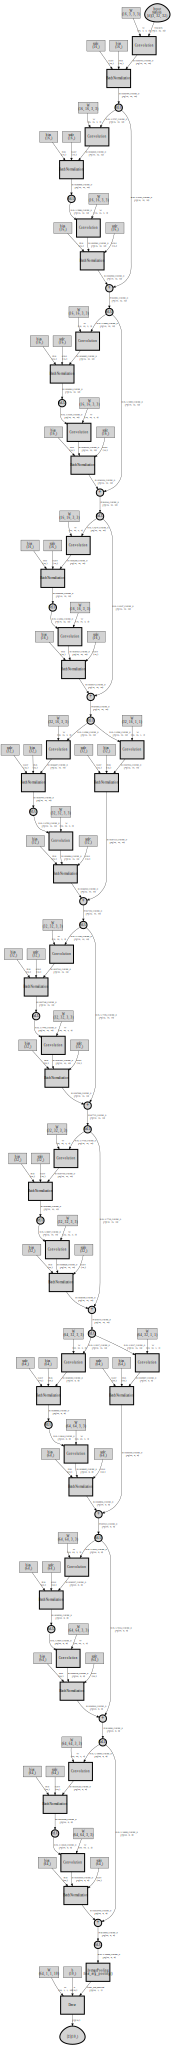

In [9]:
display(SVG("images/ResNet20_Model.svg"))

Take a moment to compare this SVG generated from the network model we created via the Microsoft Cognitive Toolkit with the ResNet20 network architecture image we looked at above.

# Preparing our Dataset

In this tutorial, we will be using the CIFAR-10 dataset (http://www.cs.toronto.edu/~kriz/cifar.html). 
CIFAR-10 is a popular dataset for image classification, collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. 
There are 50,000 training images and 10,000 test images. The 10 classes are: 
    
 * airplane, 
 * automobile, 
 * bird, 
 * cat, 
 * deer,
 * dog,
 * frog,
 * horse,
 * ship, and 
 * truck.

The CIFAR-10 dataset is not included in the Cognitive Toolkit distribution but can be easily downloaded and converted to supported 
format by the following code from Cognitive Toolkit directory `CNTK/Examples/Image/DataSets/CIFAR-10/`. We have copied this code into the `CIFAR-10` subdirectory of this lab.

We need to use one of its helper scripts to download and process CIFAR-10. Normally we would run this using Python:

    python install_cifar10.py

This Python script will download, extract, and prepare the training and test data. You will see output like:

    Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
    Done.
    Extracting files...
    Done.
    Preparing train set...
    Done.
    Preparing test set...
    Done.
    Writing train text file...
    Done.
    Writing test text file...
    Done.
    Converting train data to png images...
    Done.
    Converting test data to png images...
    Done.
    
See https://github.com/Microsoft/CNTK/tree/master/Examples/Image/DataSets/CIFAR-10 for more information.

But we can run it using the run magic command in this Jupyter-Notebook. We have a `copy_and_run.py` Python script, which copies these CIFAR-10 helper scripts to a subdirectory of `/home/nbuser/data` on Azure-Notebooks for speed and will then download, extract and prepare the training and test data.  Note that as we are using a custom script, our output will be *slightly* different to the reference output from `install_cifar10.py` above.

This takes about 15-20 minutes to run. It tries to avoid unnecessary work, and so does not run if it finds its files already there -- although if you get into trouble, you can force it to run by passing a `-f` command argument.

Unfortunately, the `/home/nbuser/data` area is quick but it is non-persistent, and will disappear at the end of your Jupyter-Notebook session. If this happens, when you run this script it will detect its files are missing and recreate as necessary.

In [10]:
%run -i CIFAR-10/copy_and_run.py

Cleaning up...
Copying utilities...
Changing directory to /home/nbuser/data/M3/CIFAR-10...
Running install_cifar10
100% Done.
Extracting files...
Done.
Preparing train set...
Done.
Preparing test set...
Done.
Writing train text file...


100%|##########| 50000/50000 [13:23<00:00, 63.49it/s]

Done.
Writing test text file...



100%|##########| 10000/10000 [02:27<00:00, 67.66it/s]

Done.
Converting train data to png images...



100%|##########| 10000/10000 [02:15<00:00, 73.98it/s]


Done.
Converting test data to png images...


100%|##########| 10000/10000 [01:40<00:00, 99.59it/s]

Done.


CIFAR-10 setup time: 2103.606474161148 s.


# Training (Optional)

The following code will train our ResNet model, using mini-batches.

We would encourage you to experiment with training if possible in this lab. The data set is small. Having a conceptual understanding of what is involved in running training is really useful for consolidating your knowledge on what these learning algorithms are doing.

However, Training can take some considerable time, even with the benefits of GPU acceleration, but especially so without. For those of you running only on a CPU (as you will be in Azure Notebooks), we have limited the number of rounds of training we do. Each round is called an *epoch*. Running for more epochs will usually result in a more accurate model, and so we are sacrificing accuracy for speed of progressing through the lab for CPU users.

If you find the training too slow, feel free to skip the entire section below and proceed to the following section where we will leverage the fact that Microsoft makes available pre-trained models for download.  To skip it, set the variable `make_model` below to `false`.

In [25]:
#
# Change this to FALSE if you want to skip training...
#

make_model = False

If you are interested in experimenting with training, you can run the code below and see how it works. Conceptually, the flow is as follows - we evaluate the error for the class prediction of a test image with a known label using our current set of weights, and then we use back-propagation to adjust our weights slightly to reduce this error. We do this for all the examples in our training set. This is one *epoch*. Then we repeat until either a fixed numer of epochs or, more likely, until our error has reduced to a suitable small number.

In practice, we are splitting our test data in smaller chunks called minibatches. When all of the training data has been processed once across a number of minibatches, this is will be an *epoch*.

Using minibatches has a number of advantages over single batch for training. Firstly, it uses less peak memory and therefore allows much larger training sets than might otherwise be feasible.  Secondly, it acts as a source of noise.  This small level of noise ensures that you escape being trapped in any local minima. Using minibatching does require that error information is accumulated across the entire epoch before doing backpropagation.

![Training Workflow](images/cnn_training.gif "Training Workflow")

If we have successfully set our default device to GPU, we will attempt to train for 50 epochs. This will take about 35 minutes with a GTX1080 Ti. If you want, you can reduce the `epochs = 50` line in the code to a smaller number, to train quicker, perhaps 5 or 1.

Otherwise if using CPU we will attempt to train for only 1 epoch (to give a feeling for training, but without worrying about the accuracy of the resulting model, as we will use the pre-trained models).  

If you have the patience and the time, we suggest also setting this to something like '5' and re-running from the top of the notebook. Compare the accuracy figures you get when evaluating your model at the end -- you should see that training for more epochs will usually give a more accurate model, up until the model converges...

In [26]:
epoch_size = 60000  # number of training examples ...
minibatch_size = 128 # examples per mini-batch for training

if isUsingGPU:
    epochs = 50
else:
    # these are the settings for CPU-only / Azure Notebooks
    # if you have time/patience, consider changing the number of epochs from 1 to 5 and running again
    epochs = 1
    if make_model:
        print("We're not using a GPU, so we're going to restrict our training for time reasons.")
        print("We'll be training for {} epoch with a training set of {} elements".format(epochs, epoch_size))
        
model_dir = './out'
if not model_dir:
    model_dir = os.path.join(abs_path, "Models")


Now that we have configured our training, we are going to create a function to split our training dataset into smaller portions called *minibatches*.

In [27]:
# Define the reader for both training and evaluation action.
def create_image_minibatch_source(map_file, mean_file, train, total_number_of_samples):
    if not os.path.exists(map_file) or not os.path.exists(mean_file):
        raise RuntimeError("File '%s' or '%s' does not exist. Please run install_cifar10.py from DataSets/CIFAR-10 to fetch them" %
                           (map_file, mean_file))

    # transformation pipeline for the features has jitter/crop only when training
    transforms = []
    if train:
        transforms += [
            xforms.crop(crop_type='randomside', side_ratio=(0.8, 1.0), jitter_type='uniratio') # train uses jitter
        ]
    transforms += [
        xforms.scale(width=image_width, height=image_height, channels=num_channels, interpolations='linear'),
        xforms.mean(mean_file)
    ]
    # deserializer
    return MinibatchSource(ImageDeserializer(map_file, StreamDefs(
        features=StreamDef(field='image', transforms=transforms), # first column in map file is referred to as 'image'
        labels=StreamDef(field='label', shape=num_classes))),     # and second as 'label'
        randomize=train,
        max_samples=total_number_of_samples,
        multithreaded_deserializer=True)



Now that we're able to divide our data into minibatches, we'll create a train and evaluation function. For now, don't worry too much about understanding all of this code. It sets some training and learning parameters, creates a trainer (using the optimization algorithm *Stochastic Gradient Descent with Momentum*), and processes the training data in mini-batches

In [28]:
# Train and evaluate the network.
def train_and_evaluate(reader_train, reader_test, epoch_size, max_epochs, profiler_dir=None,
                       model_dir=None, log_dir=None, tensorboard_logdir=None, gen_heartbeat=False):

    set_computation_network_trace_level(0)

    # shared training parameters
    l2_reg_weight = 0.0001

    # Set learning parameters
    lr_per_mb = [1.0]*80 + [0.1]*40 + [0.01]
    lr_per_sample = [lr/minibatch_size for lr in lr_per_mb]
    lr_schedule = learning_parameter_schedule_per_sample(lr_per_sample)
    mm_schedule = momentum_schedule(0.9, minibatch_size)

    # progress writers
    progress_writers = [ProgressPrinter(tag='Training', log_to_file=log_dir, gen_heartbeat=gen_heartbeat)] 

    # trainer object
    learner = momentum_sgd(resnet20_cifar10_model.parameters, lr_schedule, mm_schedule,
                           l2_regularization_weight=l2_reg_weight)
    trainer = Trainer(resnet20_cifar10_model, (ce, pe), learner, progress_writers)

    # define mapping from reader streams to network inputs
    input_map = {
        input_var: reader_train.streams.features,
        label_var: reader_train.streams.labels
    }

    # perform model training
    print('[i] Performing training...')
    for epoch in range(max_epochs): # loop over epochs
        print('[i] Processing epoch {}'.format(epoch),flush=True)
        sample_count = 0
        pbar = tqdm(total=epoch_size, ascii=True)
        while sample_count < epoch_size:  # loop over minibatches in the epoch
            current_minibatch_size = min(minibatch_size, epoch_size-sample_count)
            data = reader_train.next_minibatch(current_minibatch_size, input_map=input_map) # fetch minibatch.
            trainer.train_minibatch(data)                  # update model with it
            sample_count += current_minibatch_size         # count samples processed so far
            pbar.update(current_minibatch_size)
        pbar.close()

        trainer.summarize_training_progress()

        if model_dir:
            resnet20_cifar10_model.save(os.path.join(model_dir, network_name + "_{}.dnn".format(epoch)))

    # Evaluation parameters
    test_epoch_size = 10000
    test_minibatch_size = 16

    # process minibatches and evaluate the model
    metric_numer = 0
    metric_denom = 0
    sample_count = 0

    print('[i] Evaluating model...', flush=True)
    pbar = tqdm(total=test_epoch_size, ascii=True)
    while sample_count < test_epoch_size:
        current_minibatch_size = min(test_minibatch_size, test_epoch_size - sample_count)
        # Fetch next test min batch.
        data = reader_test.next_minibatch(current_minibatch_size, input_map=input_map)
        # minibatch data to be trained with
        metric_numer += trainer.test_minibatch(data) * current_minibatch_size
        metric_denom += current_minibatch_size
        # Keep track of the number of samples processed so far.
        sample_count += data[label_var].num_samples
        pbar.update(current_minibatch_size)
    pbar.close()

    print("")
    trainer.summarize_test_progress()
    print("")

    return resnet20_cifar10_model


## Run Training

Okay, with these functions, let's do the actual training itself.

**WARNING:** this following code block takes significant time to run, especially if you are not using a GPU.  By default, we restrict training in this lab to a single epoch if on a CPU, but it still can take 15 minutes or so (per epoch on Azure Notebooks) to complete.

In [29]:
if make_model:
    model_file = 'LocallyTrained_ResNet_20_CIFAR10_CNTK.model'
    print("make_model is true, so performing training...")
    print("Creating minibatch source for training...", flush=True)
    reader_train = create_image_minibatch_source(os.path.join(data_path, 'train_map.txt'), 
                                                 os.path.join(data_path, 'CIFAR-10_mean.xml'), 
                                                 True, 
                                                 total_number_of_samples=epochs * epoch_size)
    print("Creating minibatch source for testing...", flush=True)
    reader_test = create_image_minibatch_source(os.path.join(data_path, 'test_map.txt'), 
                                                os.path.join(data_path, 'CIFAR-10_mean.xml'), 
                                                False, 
                                                total_number_of_samples=C.io.FULL_DATA_SWEEP)

    startTime = time.time()
    trained_model = train_and_evaluate(reader_train, reader_test, epoch_size, epochs)
    endTime = time.time()
    
    print("The model took {:.4f} seconds to train".format(endTime - startTime))
    print("Saving the model as >>{}<<".format(model_file))
    
    resnet20_cifar10_model.save(os.path.join(data_path, model_file))
else:
    model_file = 'ResNet_20_CIFAR10_CNTK.model'
    print("make_model is false, so skipping training...")

make_model is false, so skipping training...


You'll see from the output above how well we did against the training set (`metric = `*xxxx*`%`) and against the test set (second `metrix = `*xxxx*`%` value). These metrics are a measure of what percentage of these sets we were correctly able to classify once we had trained our model. 

Did you notice one was more accurate than the other? Why do you think this is?

# If not Training, Download Pre-Trained Model

Microsoft maintains download links for all their pre-trained models at https://github.com/Microsoft/CNTK/blob/master/PretrainedModels/Image.md.  Some of the models are trained from scratch by the Cognitive Toolkit, and some others are converted from other toolkits such as Caffe. The models are categorized by their application domains.

We're interested in the `ResNet20_CIFAR10_CNTK.model`.

If you skipped training above, you must run this following block of code to download the model. If you have trained, it is still safe to run this if you so wish -- it will not replace your learned model with the downloaded version if `make_model` is set to `true`.  If `make_model` is set to `false`, it will download and use a pre-trained model.

In [30]:
# ==============================================================================
# Load the appropriate urlretrieve function based on Python version
try: 
    from urllib.request import urlretrieve 
except ImportError: 
    from urllib import urlretrieve
    
def ensure_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
        
def download_model(model_root = data_path):
    ensure_exists(model_root)
    resnet_model_url = 'https://www.cntk.ai/Models/CNTK_Pretrained/ResNet20_CIFAR10_CNTK.model'
    resnet_model_localfile = os.path.join(model_root, 'ResNet_20_CIFAR10_CNTK.model')
    
    try:
        urlretrieve(resnet_model_url, resnet_model_localfile)
        print('Download completed.')
        return
    except:
        print('Failed to download, retrying.')
  
    return resnet_model_localfile

if make_model != True:
    print('Downloading pre-trained model. Note: this might take a while...')
    startTime = time.time()
    download_model()
    endTime = time.time()
    print('Downloading pre-trained model complete!')
    print("The model took {:.4f} seconds to download".format(endTime - startTime))


Download completed.
The model took 1.0013 seconds to download


# Evaluation Function
We next defined some evaluation functions to allow us to inspect the performance of our classifier.

The first function will attempt to classify a single image, using the output from the softmax.

In [31]:
# Evaluates a single image using the re-trained model
def eval_single_image(loaded_model, image_path, width, height):
    try:
        img = PIL.Image.open(image_path).convert("RGBA")    
        if image_path.endswith("png"):
            temp = PIL.Image.new("RGBA", img.size, (255, 255, 255))
            temp.paste(img, img)
            img = temp
        resized = img.resize((height, width), PIL.Image.ANTIALIAS)
        bgr_image = np.asarray(resized, dtype=np.float32)[..., [2, 1, 0]]
        hwc_format = np.ascontiguousarray(np.rollaxis(bgr_image, 2))

        # compute model output
        arguments = {loaded_model.arguments[0]: [hwc_format]}
        output = loaded_model.eval(arguments)

        # return softmax probabilities
        return C.softmax(output[0]).eval()
    
    except FileNotFoundError:
        print("Could not open (skipping file): {}".format(image_path))
        return ['None']

Now that we can evaluate the predicted class probabilities of a single image, we can extend this to perform some predictions on a test set.

We're going to use the labels from the CIFAR-10, and use some Python to pretty-print the results in a Jupyter Notebook table. We're going to use a Pandas dataframe to display our results, so we need some code to setup helper routines for this.

In [32]:
#
# This code is to allow us to inline our images for display in a table...
#
from IPython.display import HTML, display
import urllib
import pandas
import PIL.Image
from io import BytesIO
import base64


pandas.set_option('display.max_colwidth', -1)

my_results = []

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def encode_image_as_base64(image_filepath):
    image = PIL.Image.open(image_filepath)    
    with BytesIO() as buffer:
        image.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def map_image_file_to_inline_image(image_filepath):
    return '<img src="data:image/jpeg;base64,{}" width=64 height=64 alt=IMAGE />'.format(encode_image_as_base64(image_filepath))


We need an evaluation function, to test a set of images against our provided model, by classifying each one and 
returning the list of predicted probabilities along with the ground truth, so let's create that next.

In [33]:
  
# Evaluates an image set using the provided model
def eval_test_images(loaded_model, test_map_file, width, height, max_images=-1, column_offset=0):
    num_images = sum(1 for line in open(test_map_file))
    if max_images > 0:
        num_images = min(num_images, max_images)
    if isUsingGPU is not False:
        num_images = min(num_images, 300) #We will run through fewer images for test run on CPU...
        
    print("Evaluating model output node '{0}' for {1} images.".format('prediction', num_images))

    pred_count = 0
    correct_count = 0
    np.seterr(over='raise') # Set numpy to raise a FloatingPointError on any overflows...
    with open(test_map_file, "r") as input_file:
        for line in input_file:
            tokens = line.rstrip().split('\t')
            img_file = tokens[0 + column_offset]
            probs = eval_single_image(loaded_model, img_file, width, height)
                
            if probs[0]=='None':
                print("Eval not possible: ", img_file)
                continue
            
            precision = "{:.4f}"
            
            pred_count += 1
            true_label = int(tokens[1 + column_offset])
            predicted_label = np.argmax(probs)

            #
            # Create a table of results, showing the image, the ground truth label, our best prediction, and
            # then the distribution of probabilities across all the classes
            my_results.append({"image_url": img_file, 
                        "truth":       labels[true_label],
                        "prediction":  labels[predicted_label],
                        labels[0]:     precision.format(probs[0]),
                        labels[1]:     precision.format(probs[1]),
                        labels[2]:     precision.format(probs[2]),
                        labels[3]:     precision.format(probs[3]),
                        labels[4]:     precision.format(probs[4]),
                        labels[5]:     precision.format(probs[5]),
                        labels[6]:     precision.format(probs[6]),
                        labels[7]:     precision.format(probs[7]),
                        labels[8]:     precision.format(probs[8]),
                        labels[9]:     precision.format(probs[9]),
                   })

            if predicted_label == true_label:
                correct_count += 1

            if pred_count % 100 == 0:
                print("Processed {0} samples ({1:.2%} correct)".format(pred_count, 
                                                                       (float(correct_count) / pred_count)))
            if pred_count >= num_images:
                break
                    
        # Let's format our results table nicely for Jupyter Notebook
        # we'll use a Pandas DataFrame, and re-order the columns slightly so that the image,
        # ground truth label and best prediction are displayed first...
        df = pandas.DataFrame(my_results)
        cols = list(df.columns.values)
        cols.pop(cols.index('image_url'))
        cols.pop(cols.index('truth'))
        cols.pop(cols.index('prediction'))
        df = df[['image_url'] + ['truth']+ ['prediction'] + cols]

        # and finally, render it as a nice HTML table below
        display(HTML(df.to_html(escape=False, formatters=dict(image_url=map_image_file_to_inline_image))))
            
    print ("{0} of {1} prediction were correct".format(correct_count, pred_count))
    return correct_count, pred_count, (float(correct_count) / pred_count)

# Run Inference

Now that we have a trained model (either trained ourselves, or downloaded), let's get it loaded, and then we can evaluate the performance of the classifier against our test set. We're going to run some Jupyter-Notebook magic next to allow our tables format a bit nicer. This is just for presentation of the output of our classifier later, and you can safely ignore the contents of the next Markdown block, but please run it by selecting it and pressing `SHIFT` + `Return`.

%%html
<!-- Some magic to ensure we can see our larger cell outputs -->
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

Now, let's see how well our model did.

Loading existing model from /home/nbuser/data/M3/CIFAR-10/ResNet_20_CIFAR10_CNTK.model
Composite(features: Tensor[3,32,32]) -> Tensor[10]
Evaluating model output node 'prediction' for 100 images.
Processed 100 samples (84.00% correct)


,image_url,truth,prediction,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,,cat,cat,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,,ship,ship,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
2,,ship,ship,0.0002,0.0017,0.0000,0.0000,0.0000,0.0000,0.0000,0.0005,0.9971,0.0004
3,,airplane,airplane,0.9457,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0541,0.0002
4,,frog,frog,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
5,,frog,frog,0.0000,0.0000,0.0001,0.0654,0.0012,0.0000,0.9320,0.0013,0.0000,0.0000
6,,automobile,automobile,0.0000,0.9999,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001
7,,frog,frog,0.0011,0.0000,0.1014,0.0179,0.0002,0.0003,0.8782,0.0003,0.0004,0.0003
8,,cat,cat,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
9,,automobile,truck,0.0003,0.2112,0.0000,0.0024,0.0001,0.0000,0.0006,0.0003,0.1054,0.6796

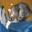
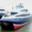
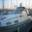
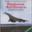
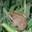
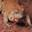
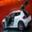
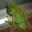
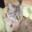
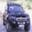
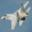
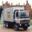
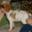
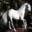
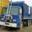
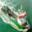
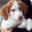
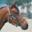
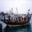
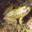
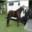
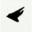
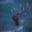
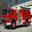
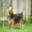
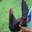
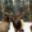
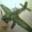
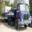
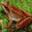
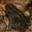
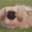
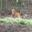
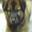
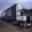
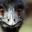
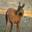
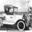
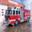
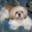
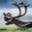
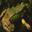
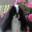
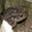
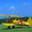
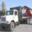
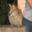
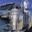
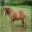
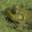
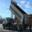
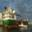
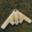
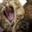
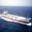
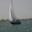
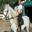
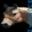
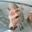
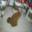
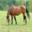
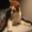
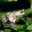
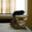
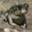
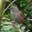
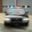
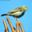
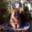
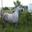
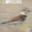
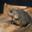
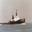
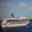
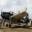
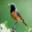
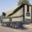
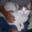
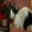
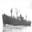
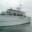
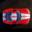
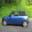
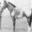
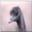
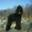
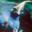
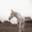
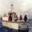
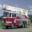
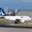
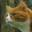
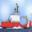
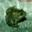
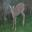
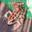
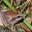
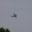
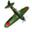
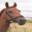

84 of 100 prediction were correct


In [34]:
full_model_file_path = os.path.join(data_path, model_file)
if model_file is not None and os.path.exists(full_model_file_path):
    print("Loading existing model from {}".format(full_model_file_path))
    trained_model = load_model(full_model_file_path)
    print("{}".format(trained_model))
    eval_test_images(trained_model, os.path.join(data_path, "test_map.txt"), 32, 32, 100)
else:
    print("No pre-existing model file - either you need to perform training, or download a model...")
    if make_model != True:
        print('Downloading pre-trained model. Note: this might take a while...')
        startTime = time.time()
        download_model()
        endTime = time.time()
        print('Downloading pre-trained model complete!')
        print("The model took {:.4f} seconds to download".format(endTime - startTime))
        trained_model = load_model(full_model_file_path)
        print("{}".format(trained_model))
        eval_test_images(trained_model, os.path.join(data_path, "test_map.txt"), 32, 32, 100)


If you were doing the training yourself on CPU, an interesting exercise is to set `make_model` to `false` and re-run the code above to download the ready-made model from Microsoft. It has been trained on a much larger number of epochs, and so will have more accurately converged to a solution.  

Compare your 1 or 5-epoch trained CPU model vs the pre-trained model. How does the accuracy differ?

# Conclusions

In this lab, we created a simple ResNet20 model, and used it to perform image classification on the CIFAR-10 dataset.

Even on this limited dataset, it is possible to see how much more accurate the CNN-based approach is than traditional classifier using hand-crafted features - for example, Viola-Jones and the HOG algorithms.

We've also seen that usually the more epochs we run training for, the more accurate our model gets - up to the point where it converges.

In the next module, we will explore in more depth how to extend these CNN-based classifiers to make object detectors, and we will introduce the concepts of segmentation.

